In [1]:
import os
import numpy as np
import imageio
import scipy
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from PIL import Image
from itertools                  import product
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2023-08-18 15:07:09.564228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# def remove_color_profile(image_path, output_path):
#     img = Image.open(image_path)
#     img = img.convert("RGB")
#     img.save(output_path, format="PNG")

# def process_folder(folder_path):
#     for root, _, files in os.walk(folder_path):
#         for filename in files:
#             if filename.lower().endswith(".png"):
#                 input_path = os.path.join(root, filename)
#                 output_path = input_path  
                
#                 remove_color_profile(input_path, output_path)
#                 print(f"Processed: {input_path}")

# input_folder = '/Users/arina/study/ds/project/food_recommendation/bbc_goodfood/project_food/notebooks/model/photo2ingredients/grocery_store/copy_dataset/GroceryStoreDataset/dataset'
# process_folder(input_folder)

In [3]:
# TRAIN_DIR = '/Users/allaartukevic/arina/food_project/model/photo2ingredients/grocery_store/GroceryStoreDataset/dataset/train'
# TEST_DIR = '/Users/allaartukevic/arina/food_project/model/photo2ingredients/grocery_store/GroceryStoreDataset/dataset/test'
# VALIDATION_DIR = '/Users/allaartukevic/arina/food_project/model/photo2ingredients/grocery_store/GroceryStoreDataset/dataset/val'

TRAIN_DIR = '/Users/allaartukevic/arina/food_project/model/photo2ingredients/archive/train'
TEST_DIR = '/Users/allaartukevic/arina/food_project/model/photo2ingredients/archive/test'
VALIDATION_DIR = '/Users/allaartukevic/arina/food_project/model/photo2ingredients/archive/validation'

batch_size = 32
img_size = 224


#### Define sets

In [4]:
training_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="training",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="validation",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 3115 files belonging to 36 classes.
Using 2492 files for training.
Found 359 files belonging to 36 classes.
Found 3115 files belonging to 36 classes.
Using 623 files for validation.


In [5]:
train_class_names = training_set.class_names
list(map(str.lower, train_class_names))

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [6]:
y_train = training_set.class_names
y_test = test_set.class_names
y_validation = validation_set.class_names

In [7]:
set(y_train) - set(y_test)

set()

#### example of images in train dataset

2023-08-18 15:07:18.941139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:07:19.155487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


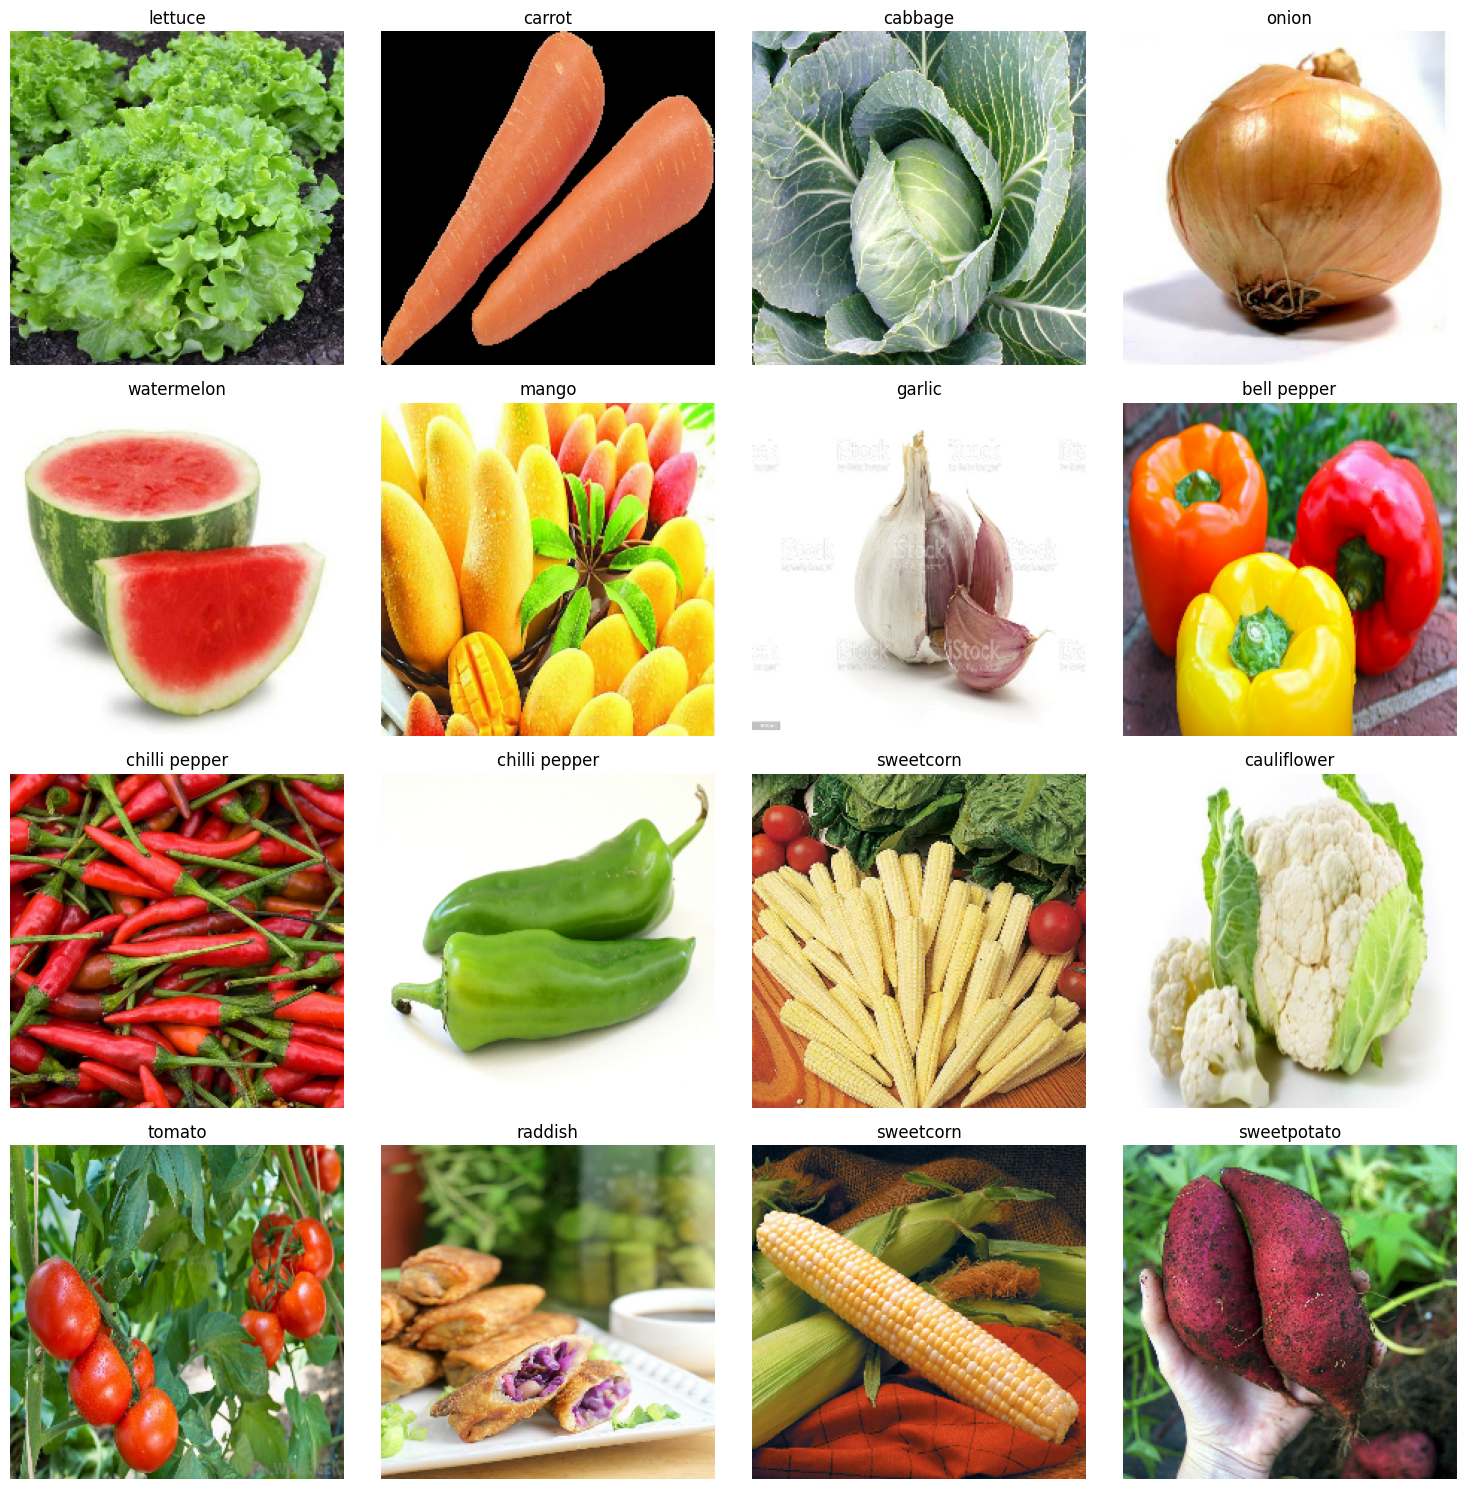

In [8]:
num_rows = 4
num_cols = 4
plt.figure(figsize=(15, 15))

for images, labels in training_set.take(1): 
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(y_train[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

#### Building model

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False

In [10]:
inputs_layer = tf.keras.Input(shape=(img_size, img_size, 3))

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs_layer)

x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)(x)

# x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# x = base_model(x, training=False)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs_layer = tf.keras.layers.Dense(units=len(training_set.class_names), activation='softmax')(x)

In [11]:
model = tf.keras.Model(inputs=inputs_layer, outputs=outputs_layer, name="photo2ingredients")

In [12]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

In [13]:
model.summary()

Model: "photo2ingredients"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                         

In [14]:
history = model.fit(x=training_set,
                    epochs=6,
                    validation_data=validation_set
                    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, verbose=1, restore_best_weights=True)]
                    )

Epoch 1/6


2023-08-18 15:07:29.892687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:07:30.098295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 51s - loss: 3.8606 - accuracy: 0.0312     

2023-08-18 15:07:32.105407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/78 [==>...........................] - ETA: 47s - loss: 3.4976 - accuracy: 0.1250

2023-08-18 15:07:35.732693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 42s - loss: 2.9554 - accuracy: 0.2729

2023-08-18 15:07:40.782604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 40s - loss: 2.7878 - accuracy: 0.3142

2023-08-18 15:07:42.757340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 39s - loss: 2.6782 - accuracy: 0.3375

2023-08-18 15:07:44.368862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 38s - loss: 2.5640 - accuracy: 0.3622

2023-08-18 15:07:45.410946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 36s - loss: 2.4930 - accuracy: 0.3750

2023-08-18 15:07:46.808113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:07:46.917139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/78 [========>.....................] - ETA: 36s - loss: 2.4469 - accuracy: 0.3850

2023-08-18 15:07:48.220819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 35s - loss: 2.3999 - accuracy: 0.3954

2023-08-18 15:07:48.466090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:07:48.760872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 35s - loss: 2.3490 - accuracy: 0.4062

2023-08-18 15:07:49.536403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/78 [===========>..................] - ETA: 31s - loss: 2.1587 - accuracy: 0.4498

2023-08-18 15:07:53.401041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/78 [===============>..............] - ETA: 24s - loss: 1.9440 - accuracy: 0.4913

2023-08-18 15:08:00.276707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/78 [====================>.........] - ETA: 14s - loss: 1.7464 - accuracy: 0.5296

2023-08-18 15:08:10.057270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 13s - loss: 1.7395 - accuracy: 0.5312

2023-08-18 15:08:10.573368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 13s - loss: 1.7291 - accuracy: 0.5334

2023-08-18 15:08:11.493434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:08:11.630034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 11s - loss: 1.7058 - accuracy: 0.5389

2023-08-18 15:08:12.371682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 1.5321 - accuracy: 0.5807

2023-08-18 15:08:24.966925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:08:27.970996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 74s 869ms/step - loss: 1.5321 - accuracy: 0.5807 - val_loss: 0.9637 - val_accuracy: 0.6966
Epoch 2/6


2023-08-18 15:08:41.272204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:08:41.483975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 50s - loss: 0.6119 - accuracy: 0.8438 

2023-08-18 15:08:43.454005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 48s - loss: 0.7824 - accuracy: 0.7723

2023-08-18 15:08:47.039393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 43s - loss: 0.8199 - accuracy: 0.7563

2023-08-18 15:08:52.198636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 41s - loss: 0.8095 - accuracy: 0.7517

2023-08-18 15:08:54.164241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 39s - loss: 0.8028 - accuracy: 0.7531

2023-08-18 15:08:55.871697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 38s - loss: 0.8082 - accuracy: 0.7500

2023-08-18 15:08:56.899710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 36s - loss: 0.8062 - accuracy: 0.7513

2023-08-18 15:08:58.279567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:08:58.391993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 36s - loss: 0.8007 - accuracy: 0.7464

2023-08-18 15:08:59.855863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:09:00.168275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 35s - loss: 0.7895 - accuracy: 0.7512

2023-08-18 15:09:00.433347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 34s - loss: 0.7918 - accuracy: 0.7522

2023-08-18 15:09:01.179800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/78 [============>.................] - ETA: 30s - loss: 0.7836 - accuracy: 0.7546

2023-08-18 15:09:05.195713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 23s - loss: 0.7751 - accuracy: 0.7628

2023-08-18 15:09:12.174735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 13s - loss: 0.7489 - accuracy: 0.7737

2023-08-18 15:09:22.224526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 13s - loss: 0.7474 - accuracy: 0.7738

2023-08-18 15:09:22.747009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/78 [======================>.......] - ETA: 12s - loss: 0.7446 - accuracy: 0.7750

2023-08-18 15:09:23.655330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:09:23.789864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/78 [======================>.......] - ETA: 11s - loss: 0.7387 - accuracy: 0.7752

2023-08-18 15:09:24.545601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 0.7241 - accuracy: 0.7769

2023-08-18 15:09:35.103460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:09:38.158857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 71s 860ms/step - loss: 0.7241 - accuracy: 0.7769 - val_loss: 0.8476 - val_accuracy: 0.7255
Epoch 3/6


2023-08-18 15:09:51.902207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:09:52.117759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 50s - loss: 0.4578 - accuracy: 0.8281 

2023-08-18 15:09:54.076763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 48s - loss: 0.5211 - accuracy: 0.8170

2023-08-18 15:09:57.644660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 46s - loss: 0.4635 - accuracy: 0.8438

2023-08-18 15:10:03.711672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 44s - loss: 0.4788 - accuracy: 0.8403

2023-08-18 15:10:06.287114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 42s - loss: 0.4871 - accuracy: 0.8344

2023-08-18 15:10:07.777799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 42s - loss: 0.5025 - accuracy: 0.8281

2023-08-18 15:10:08.863134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 40s - loss: 0.5034 - accuracy: 0.8255

2023-08-18 15:10:10.211029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:10:10.324727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 38s - loss: 0.5076 - accuracy: 0.8233

2023-08-18 15:10:11.863747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:10:12.160142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 37s - loss: 0.5085 - accuracy: 0.8218

2023-08-18 15:10:12.436529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 37s - loss: 0.5001 - accuracy: 0.8270

2023-08-18 15:10:13.155287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/78 [============>.................] - ETA: 32s - loss: 0.5116 - accuracy: 0.8199

2023-08-18 15:10:17.149391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/78 [===============>..............] - ETA: 25s - loss: 0.5130 - accuracy: 0.8241

2023-08-18 15:10:24.010536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 14s - loss: 0.5162 - accuracy: 0.8244

2023-08-18 15:10:33.863726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:10:34.396934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 13s - loss: 0.5142 - accuracy: 0.8252

2023-08-18 15:10:35.336291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:10:35.467185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 12s - loss: 0.5206 - accuracy: 0.8227

2023-08-18 15:10:36.260655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.8238

2023-08-18 15:10:47.307896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:10:50.366925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 72s 875ms/step - loss: 0.5291 - accuracy: 0.8238 - val_loss: 0.9017 - val_accuracy: 0.7191
Epoch 4/6


2023-08-18 15:11:03.721391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:11:03.931063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 51s - loss: 0.2802 - accuracy: 0.8750 

2023-08-18 15:11:05.915556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 49s - loss: 0.4453 - accuracy: 0.8080

2023-08-18 15:11:09.517303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 43s - loss: 0.4389 - accuracy: 0.8208

2023-08-18 15:11:14.653787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 41s - loss: 0.4460 - accuracy: 0.8212

2023-08-18 15:11:16.651348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 39s - loss: 0.4395 - accuracy: 0.8266

2023-08-18 15:11:18.281669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 39s - loss: 0.4347 - accuracy: 0.8310

2023-08-18 15:11:19.591147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 38s - loss: 0.4272 - accuracy: 0.8333

2023-08-18 15:11:21.534132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:11:21.654617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 37s - loss: 0.4132 - accuracy: 0.8413

2023-08-18 15:11:23.102310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:11:23.374924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:11:23.607007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 37s - loss: 0.4193 - accuracy: 0.8380

2023-08-18 15:11:24.395884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/78 [===========>..................] - ETA: 32s - loss: 0.4329 - accuracy: 0.8362

2023-08-18 15:11:28.206403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/78 [===============>..............] - ETA: 25s - loss: 0.4417 - accuracy: 0.8408

2023-08-18 15:11:36.275713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 14s - loss: 0.4509 - accuracy: 0.8411

2023-08-18 15:11:46.259050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:11:46.801191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/78 [======================>.......] - ETA: 13s - loss: 0.4508 - accuracy: 0.8417

2023-08-18 15:11:47.676946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:11:47.780061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 12s - loss: 0.4541 - accuracy: 0.8407

2023-08-18 15:11:48.526724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8455

2023-08-18 15:11:59.638347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:12:02.647492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 73s 887ms/step - loss: 0.4458 - accuracy: 0.8455 - val_loss: 0.8253 - val_accuracy: 0.7480
Epoch 5/6


2023-08-18 15:12:16.389528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:12:16.605099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 51s - loss: 0.3257 - accuracy: 0.8750 

2023-08-18 15:12:18.567172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 48s - loss: 0.4093 - accuracy: 0.8616

2023-08-18 15:12:22.135444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 43s - loss: 0.4189 - accuracy: 0.8604

2023-08-18 15:12:27.296962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 40s - loss: 0.4254 - accuracy: 0.8594

2023-08-18 15:12:29.281564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 39s - loss: 0.4245 - accuracy: 0.8547

2023-08-18 15:12:30.909812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 38s - loss: 0.4216 - accuracy: 0.8537

2023-08-18 15:12:31.903175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 36s - loss: 0.4135 - accuracy: 0.8568

2023-08-18 15:12:33.257760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:12:33.376581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 35s - loss: 0.4214 - accuracy: 0.8570

2023-08-18 15:12:34.907387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:12:35.149674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 35s - loss: 0.4283 - accuracy: 0.8553

2023-08-18 15:12:35.439189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 34s - loss: 0.4248 - accuracy: 0.8583

2023-08-18 15:12:36.190057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/78 [============>.................] - ETA: 30s - loss: 0.4249 - accuracy: 0.8575

2023-08-18 15:12:40.114572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


43/78 [===============>..............] - ETA: 24s - loss: 0.4034 - accuracy: 0.8670

2023-08-18 15:12:46.830082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/78 [====================>.........] - ETA: 14s - loss: 0.3951 - accuracy: 0.8701

2023-08-18 15:12:56.705594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 13s - loss: 0.3938 - accuracy: 0.8696

2023-08-18 15:12:57.233779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/78 [======================>.......] - ETA: 12s - loss: 0.3919 - accuracy: 0.8703

2023-08-18 15:12:58.159196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:12:58.260404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 11s - loss: 0.3914 - accuracy: 0.8709

2023-08-18 15:12:59.008116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8688

2023-08-18 15:13:10.094955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:13:13.072731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 70s 852ms/step - loss: 0.3860 - accuracy: 0.8688 - val_loss: 0.8839 - val_accuracy: 0.7287
Epoch 6/6


2023-08-18 15:13:26.501012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:13:26.728726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 49s - loss: 0.3512 - accuracy: 0.8906 

2023-08-18 15:13:28.713739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 48s - loss: 0.2831 - accuracy: 0.9062

2023-08-18 15:13:32.314615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 43s - loss: 0.3305 - accuracy: 0.8958

2023-08-18 15:13:37.412378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 40s - loss: 0.3287 - accuracy: 0.8941

2023-08-18 15:13:39.615471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 39s - loss: 0.3262 - accuracy: 0.8953

2023-08-18 15:13:41.176909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 38s - loss: 0.3227 - accuracy: 0.8977

2023-08-18 15:13:42.194631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 37s - loss: 0.3275 - accuracy: 0.8958

2023-08-18 15:13:43.786377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:13:43.921416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 36s - loss: 0.3228 - accuracy: 0.8966

2023-08-18 15:13:45.403247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:13:45.722614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:13:45.977191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 35s - loss: 0.3298 - accuracy: 0.8940

2023-08-18 15:13:46.767486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/78 [===========>..................] - ETA: 32s - loss: 0.3222 - accuracy: 0.8958

2023-08-18 15:13:50.452272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/78 [===============>..............] - ETA: 25s - loss: 0.3193 - accuracy: 0.8951

2023-08-18 15:13:57.158911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/78 [====================>.........] - ETA: 14s - loss: 0.3135 - accuracy: 0.8975

2023-08-18 15:14:06.783734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:14:07.295714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 13s - loss: 0.3126 - accuracy: 0.8976

2023-08-18 15:14:08.099537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:14:08.198239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/78 [======================>.......] - ETA: 12s - loss: 0.3113 - accuracy: 0.8979

2023-08-18 15:14:09.181958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9053

2023-08-18 15:14:21.181431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:14:24.440631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 72s 872ms/step - loss: 0.2961 - accuracy: 0.9053 - val_loss: 0.7541 - val_accuracy: 0.7737


In [15]:
predictions = model.predict(test_set, verbose=1)

2023-08-18 15:14:38.062293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/12 [=>............................] - ETA: 1:04

2023-08-18 15:14:40.544933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 11s 496ms/step


In [16]:
test_class_names = test_set.class_names

In [17]:
labels_array = np.array([])
pred_array = np.array([])

for x, y in test_set.take(1):
    pred_prob = model.predict(x)
    labels_array = np.concatenate([labels_array, y])
    pred_class = np.argmax(pred_prob, axis=1)
    pred_array = np.concatenate([pred_array, pred_class])    
    
print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))
print(len(labels_array))
label_vs_pred = [(training_set.class_names[int(label)], training_set.class_names[int(pred_val)]) for label, pred_val in zip(labels_array, pred_array) if label != pred_val]
print(label_vs_pred)

2023-08-18 15:14:48.666030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 1s 1s/step
Accuracy On Test Dataset:  0.875
32
[('corn', 'sweetcorn'), ('turnip', 'raddish'), ('potato', 'mango'), ('paprika', 'bell pepper')]


In [18]:
def plot_graghs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

#### Mistakes in test dataset

In [19]:
# plt.figure(figsize=(15, 10))
# for images, labels in test_set.take(1):
#     for i in range(len(images)):
#         plt.subplot(4, 8, i + 1) 
#         plt.imshow(images[i].numpy().astype('uint8'))
#         predicted_class = np.argmax(predictions[i])
#         confidence = predictions[i][predicted_class]
#         true_class = test_class_names[labels[i]]
#         predicted_class_name = test_class_names[predicted_class]
#         # plt.title(f"{true_class, tf.get_static_value(labels[i])} \n {predicted_class_name, predicted_class}")
#         plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
#         plt.axis('off')
# plt.tight_layout()
# plt.show()

In [20]:
# for images, labels in test_set:
#     predictions = model.predict(images)
#     predicted_class = np.argmax(predictions[0])
#     true_class = test_class_names[labels[0]]
    
#     if predicted_class != labels[0]: 
#         plt.figure()
#         plt.imshow(images[0].numpy().astype('uint8'))
#         confidence = predictions[0][predicted_class]
#         predicted_class_name = test_class_names[predicted_class]
#         plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
#         plt.axis('off')
        
# plt.show()

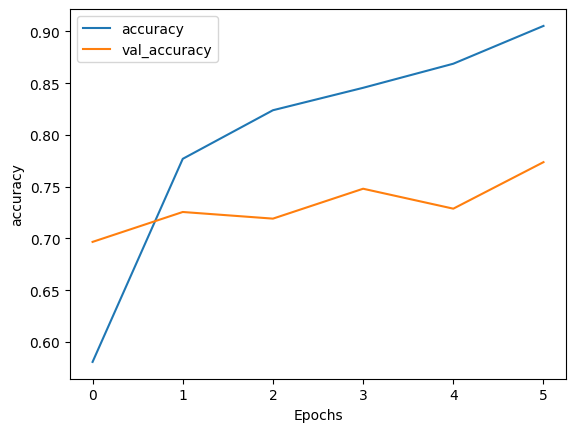

In [21]:
plot_graghs(history, 'accuracy')

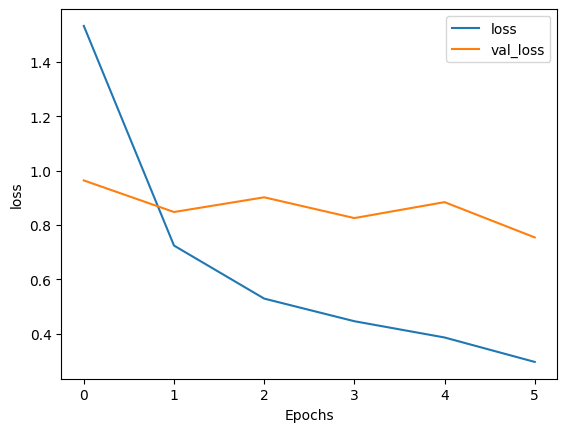

In [22]:
plot_graghs(history, 'loss')

In [23]:
# model.save("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/photo2ingredients.h5")

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# model = keras.models.load_model("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/photo2ingredients.h5")

In [25]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix


In [26]:
train_pred = model.predict(training_set)
test_pred = model.predict(test_set)

train_pred_labels = np.argmax(train_pred, axis=1)
test_pred_labels = np.argmax(test_pred, axis=1)

train_true_labels = np.concatenate([y for x, y in training_set], axis=0)
test_true_labels = np.concatenate([y for x, y in test_set], axis=0)


2023-08-18 15:14:58.223191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:14:58.434176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 44s 

2023-08-18 15:15:00.283103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 43s

2023-08-18 15:15:03.450872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/78 [=====>........................] - ETA: 38s

2023-08-18 15:15:08.511892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 37s

2023-08-18 15:15:10.690248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 36s

2023-08-18 15:15:12.090489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 36s

2023-08-18 15:15:13.020888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/78 [========>.....................] - ETA: 34s

2023-08-18 15:15:14.325423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:15:14.439445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 34s

2023-08-18 15:15:15.876576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:15:16.156111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 33s

2023-08-18 15:15:16.447707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 32s

2023-08-18 15:15:17.236246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/78 [============>.................] - ETA: 28s

2023-08-18 15:15:21.139746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/78 [================>.............] - ETA: 21s

2023-08-18 15:15:27.783786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 12s

2023-08-18 15:15:36.936709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/78 [======================>.......] - ETA: 11s

2023-08-18 15:15:37.425319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 10s

2023-08-18 15:15:38.297391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:15:38.412375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 9s 

2023-08-18 15:15:39.208553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 53s 624ms/step


2023-08-18 15:15:49.911098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:15:52.345258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 10s 484ms/step


2023-08-18 15:16:01.089204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:01.296492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:02.655555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:04.564408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:07.810241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:09.125544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:10.185766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:10.880549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:11.758109: W tensorflow/core/lib/png/png_io.cc:88] PNG 

In [27]:
result = [(training_set.class_names[int(label)], training_set.class_names[int(pred)]) for label, pred in zip(train_true_labels, train_pred_labels) if label != pred]
print(len(result))

2422


In [28]:
result = [(label, pred) for label, pred in zip(test_true_labels, test_pred_labels) if label != pred]
print(result)

[(27, 15), (34, 3), (9, 12), (5, 12), (25, 34), (19, 1), (15, 25), (16, 25), (25, 11), (27, 16), (8, 7), (26, 27), (2, 9), (11, 21), (32, 15), (26, 10), (20, 2), (0, 26), (23, 28), (13, 22), (15, 3), (27, 33), (3, 25), (26, 11), (0, 25), (1, 7), (17, 11), (13, 9), (19, 23), (4, 19), (9, 6), (32, 9), (12, 30), (0, 15), (25, 11), (19, 28), (18, 16), (22, 3), (18, 1), (32, 17), (34, 9), (6, 16), (27, 26), (17, 29), (13, 7), (20, 2), (17, 5), (25, 31), (26, 32), (16, 31), (8, 7), (11, 30), (33, 17), (8, 21), (28, 21), (5, 24), (12, 28), (6, 24), (9, 19), (35, 33), (25, 3), (22, 19), (34, 18), (1, 30), (22, 14), (25, 6), (22, 3), (19, 28), (20, 11), (35, 33), (27, 6), (31, 11), (34, 2), (11, 34), (35, 0), (3, 2), (7, 3), (30, 6), (5, 10), (35, 17), (28, 20), (1, 33), (20, 25), (15, 17), (10, 0), (25, 17), (11, 4), (16, 23), (29, 10), (9, 34), (16, 20), (19, 34), (0, 25), (31, 21), (3, 21), (14, 0), (3, 19), (10, 22), (32, 9), (22, 10), (24, 17), (7, 4), (14, 16), (0, 31), (22, 13), (31, 30)

In [29]:
train_confusion_mtx = confusion_matrix(train_true_labels, train_pred_labels)
train_classification_rep = classification_report(train_true_labels, train_pred_labels)

test_confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)
test_classification_rep = classification_report(test_true_labels, test_pred_labels)


In [30]:
train_confusion_mtx = confusion_matrix(train_true_labels, train_pred_labels)
train_classification_rep = classification_report(train_true_labels, train_pred_labels)

test_confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)
test_classification_rep = classification_report(test_true_labels, test_pred_labels)


In [31]:
print("Train Confusion Matrix:")
print(train_confusion_mtx)
print("\nTrain Classification Report:")
print(train_classification_rep)

print("\nTest Confusion Matrix:")
print(test_confusion_mtx)
print("\nTest Classification Report:")
print(test_classification_rep)


Train Confusion Matrix:
[[2 0 1 ... 5 0 1]
 [0 0 2 ... 0 3 2]
 [4 3 1 ... 0 1 3]
 ...
 [0 0 4 ... 5 0 1]
 [3 1 2 ... 1 3 1]
 [0 2 3 ... 0 1 4]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.04      0.04        52
           1       0.00      0.00      0.00        62
           2       0.01      0.01      0.01        76
           3       0.04      0.07      0.05        74
           4       0.05      0.05      0.05        76
           5       0.00      0.00      0.00        68
           6       0.04      0.04      0.04        68
           7       0.03      0.03      0.03        62
           8       0.04      0.03      0.03        72
           9       0.01      0.02      0.01        64
          10       0.00      0.00      0.00        77
          11       0.04      0.04      0.04        73
          12       0.07      0.07      0.07        72
          13       0.02      0.02      0.02        59
          14   

In [32]:
training_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="training",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="validation",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 3115 files belonging to 36 classes.
Using 2492 files for training.
Found 359 files belonging to 36 classes.
Found 3115 files belonging to 36 classes.
Using 623 files for validation.


In [33]:
from tensorflow.keras import layers, models
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

In [34]:
image_size = (img_size, img_size)
num_classes = len(training_set.class_names)  

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
])

simple_model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    data_augmentation,
    preprocessing.Rescaling(1.0 / 255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

simple_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_simple = simple_model.fit(training_set, validation_data=validation_set, epochs=10)


Epoch 1/10


/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-08-18 15:16:39.555805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:16:39.767995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:16 - loss: 4.3588 - accuracy: 0.0156

2023-08-18 15:16:42.639853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:11 - loss: 3.8776 - accuracy: 0.0536

2023-08-18 15:16:47.940047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 3.7161 - accuracy: 0.0479

2023-08-18 15:16:55.934016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 3.6890 - accuracy: 0.0441

2023-08-18 15:16:58.312136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 1:00 - loss: 3.6712 - accuracy: 0.0493

2023-08-18 15:17:00.117342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 59s - loss: 3.6611 - accuracy: 0.0484 

2023-08-18 15:17:01.210814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 58s - loss: 3.6537 - accuracy: 0.0491

2023-08-18 15:17:02.738333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 57s - loss: 3.6428 - accuracy: 0.0526

2023-08-18 15:17:03.139479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 3.6172 - accuracy: 0.0481

2023-08-18 15:17:07.004408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:17:07.306370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 3.6079 - accuracy: 0.0544

2023-08-18 15:17:08.085543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 3.5987 - accuracy: 0.0569

2023-08-18 15:17:09.413882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 3.5551 - accuracy: 0.0580

2023-08-18 15:17:15.918919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 3.5039 - accuracy: 0.0689

2023-08-18 15:17:26.373586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 3.4262 - accuracy: 0.0797

2023-08-18 15:17:40.222603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 3.4206 - accuracy: 0.0816

2023-08-18 15:17:41.154344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 3.4106 - accuracy: 0.0815

2023-08-18 15:17:43.222865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:17:43.328575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 3.3999 - accuracy: 0.0823

2023-08-18 15:17:45.149991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 3.3156 - accuracy: 0.1015

2023-08-18 15:17:59.289497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:18:02.247448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 93s 1s/step - loss: 3.3156 - accuracy: 0.1015 - val_loss: 2.8071 - val_accuracy: 0.1605
Epoch 2/10


2023-08-18 15:18:11.614161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:18:11.825983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:18 - loss: 2.8258 - accuracy: 0.0781

2023-08-18 15:18:14.281269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:09 - loss: 2.8348 - accuracy: 0.1607

2023-08-18 15:18:19.073467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/78 [=====>........................] - ETA: 1:00 - loss: 2.8303 - accuracy: 0.1621

2023-08-18 15:18:28.003034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 59s - loss: 2.8278 - accuracy: 0.1632 

2023-08-18 15:18:30.195155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 59s - loss: 2.8294 - accuracy: 0.1612

2023-08-18 15:18:32.019262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 58s - loss: 2.8453 - accuracy: 0.1578

2023-08-18 15:18:33.144730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 56s - loss: 2.8586 - accuracy: 0.1520

2023-08-18 15:18:34.744306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:18:34.919089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 2.8489 - accuracy: 0.1502

2023-08-18 15:18:38.385615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:18:38.686734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 2.8463 - accuracy: 0.1458

2023-08-18 15:18:39.449461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 2.8405 - accuracy: 0.1451

2023-08-18 15:18:40.844791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 2.8204 - accuracy: 0.1545

2023-08-18 15:18:47.381319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 2.7754 - accuracy: 0.1790

2023-08-18 15:18:57.368645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 2.7434 - accuracy: 0.1902

2023-08-18 15:19:11.280879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 2.7529 - accuracy: 0.1891

2023-08-18 15:19:12.234604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 2.7439 - accuracy: 0.1926

2023-08-18 15:19:14.390487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:19:14.495750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 2.7355 - accuracy: 0.1930

2023-08-18 15:19:16.213869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 2.6951 - accuracy: 0.2014

2023-08-18 15:19:30.467388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:19:33.308863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 2.6951 - accuracy: 0.2014 - val_loss: 2.6556 - val_accuracy: 0.2183
Epoch 3/10


2023-08-18 15:19:42.542706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:19:42.758199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:16 - loss: 2.7143 - accuracy: 0.2031

2023-08-18 15:19:45.271215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:11 - loss: 2.6273 - accuracy: 0.2143

2023-08-18 15:19:50.527513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 2.6064 - accuracy: 0.2271

2023-08-18 15:19:58.463282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 2.5749 - accuracy: 0.2371

2023-08-18 15:20:00.679572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 1:01 - loss: 2.5701 - accuracy: 0.2413

2023-08-18 15:20:02.326235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 59s - loss: 2.5687 - accuracy: 0.2406 

2023-08-18 15:20:03.690216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 58s - loss: 2.5660 - accuracy: 0.2366

2023-08-18 15:20:05.168395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 57s - loss: 2.5763 - accuracy: 0.2315

2023-08-18 15:20:05.655491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 2.5693 - accuracy: 0.2356

2023-08-18 15:20:09.478893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:20:09.765583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 2.5542 - accuracy: 0.2396

2023-08-18 15:20:10.554966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 2.5437 - accuracy: 0.2388

2023-08-18 15:20:11.954704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 2.5092 - accuracy: 0.2536

2023-08-18 15:20:18.643001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 35s - loss: 2.4968 - accuracy: 0.2621

2023-08-18 15:20:29.401421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 2.4382 - accuracy: 0.2742

2023-08-18 15:20:42.963535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 2.4390 - accuracy: 0.2749

2023-08-18 15:20:43.960753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 2.4279 - accuracy: 0.2777

2023-08-18 15:20:46.076476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:20:46.281404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 2.4246 - accuracy: 0.2763

2023-08-18 15:20:48.015265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 2.4094 - accuracy: 0.2769

2023-08-18 15:21:02.149998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:21:04.966351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 92s 1s/step - loss: 2.4094 - accuracy: 0.2769 - val_loss: 2.3616 - val_accuracy: 0.2970
Epoch 4/10


2023-08-18 15:21:14.321473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:21:14.530209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:17 - loss: 2.3077 - accuracy: 0.2812

2023-08-18 15:21:16.980836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:10 - loss: 2.3292 - accuracy: 0.2768

2023-08-18 15:21:22.161184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 2.2600 - accuracy: 0.2937

2023-08-18 15:21:30.070328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 2.2843 - accuracy: 0.2868

2023-08-18 15:21:32.419716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 59s - loss: 2.3023 - accuracy: 0.2780 

2023-08-18 15:21:34.187526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 58s - loss: 2.2977 - accuracy: 0.2812

2023-08-18 15:21:35.368395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 57s - loss: 2.2866 - accuracy: 0.2887

2023-08-18 15:21:36.904006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 56s - loss: 2.2922 - accuracy: 0.2912

2023-08-18 15:21:37.263322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 2.2860 - accuracy: 0.2849

2023-08-18 15:21:41.144926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:21:41.426554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 2.2847 - accuracy: 0.2812

2023-08-18 15:21:42.251913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 2.2864 - accuracy: 0.2846

2023-08-18 15:21:43.709654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 2.3002 - accuracy: 0.2911

2023-08-18 15:21:50.166264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 2.2940 - accuracy: 0.2919

2023-08-18 15:22:00.604765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 2.2748 - accuracy: 0.3006

2023-08-18 15:22:14.418797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 2.2819 - accuracy: 0.2998

2023-08-18 15:22:15.382043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 2.2854 - accuracy: 0.2997

2023-08-18 15:22:17.569576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:22:17.780979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 2.2730 - accuracy: 0.3026

2023-08-18 15:22:19.457938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 2.2638 - accuracy: 0.3082

2023-08-18 15:22:33.442329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:22:36.322656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 2.2638 - accuracy: 0.3082 - val_loss: 2.2970 - val_accuracy: 0.3146
Epoch 5/10


2023-08-18 15:22:45.670653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:22:45.881889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:17 - loss: 2.1203 - accuracy: 0.3906

2023-08-18 15:22:48.318633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:11 - loss: 2.1006 - accuracy: 0.3661

2023-08-18 15:22:53.383268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 2.1708 - accuracy: 0.3208

2023-08-18 15:23:01.426327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 2.1793 - accuracy: 0.3254

2023-08-18 15:23:03.841433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 1:00 - loss: 2.1581 - accuracy: 0.3289

2023-08-18 15:23:05.532161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 59s - loss: 2.1528 - accuracy: 0.3250 

2023-08-18 15:23:06.810453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 58s - loss: 2.1539 - accuracy: 0.3214

2023-08-18 15:23:08.368112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 57s - loss: 2.1581 - accuracy: 0.3239

2023-08-18 15:23:08.876830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 53s - loss: 2.1746 - accuracy: 0.3209

2023-08-18 15:23:12.791844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:23:13.109751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 2.1782 - accuracy: 0.3194

2023-08-18 15:23:13.902073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 2.1753 - accuracy: 0.3181

2023-08-18 15:23:15.348460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 44s - loss: 2.1812 - accuracy: 0.3223

2023-08-18 15:23:22.503132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 35s - loss: 2.1450 - accuracy: 0.3359

2023-08-18 15:23:32.167299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 2.1234 - accuracy: 0.3464

2023-08-18 15:23:45.959768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 2.1168 - accuracy: 0.3480

2023-08-18 15:23:46.896970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 2.1107 - accuracy: 0.3499

2023-08-18 15:23:49.035806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:23:49.235291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 2.0989 - accuracy: 0.3566

2023-08-18 15:23:50.917210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 2.1220 - accuracy: 0.3483

2023-08-18 15:24:04.959818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:24:07.836581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 2.1220 - accuracy: 0.3483 - val_loss: 2.2968 - val_accuracy: 0.2937
Epoch 6/10


2023-08-18 15:24:17.167105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:24:17.373948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:16 - loss: 1.9900 - accuracy: 0.3750

2023-08-18 15:24:19.866582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:10 - loss: 2.0592 - accuracy: 0.3304

2023-08-18 15:24:24.990198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 2.0493 - accuracy: 0.3458

2023-08-18 15:24:32.997831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 2.0618 - accuracy: 0.3456

2023-08-18 15:24:35.457402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 59s - loss: 2.0396 - accuracy: 0.3487 

2023-08-18 15:24:37.334729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 59s - loss: 2.0434 - accuracy: 0.3500

2023-08-18 15:24:38.611263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 57s - loss: 2.0182 - accuracy: 0.3580

2023-08-18 15:24:40.111614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:24:40.268901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 2.0304 - accuracy: 0.3582

2023-08-18 15:24:44.095805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:24:44.398339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 2.0335 - accuracy: 0.3565

2023-08-18 15:24:45.169609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 2.0343 - accuracy: 0.3527

2023-08-18 15:24:46.626902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 2.0230 - accuracy: 0.3661

2023-08-18 15:24:53.087133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 2.0177 - accuracy: 0.3658

2023-08-18 15:25:02.807600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 2.0443 - accuracy: 0.3642

2023-08-18 15:25:16.392519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 2.0470 - accuracy: 0.3633

2023-08-18 15:25:17.437280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 2.0582 - accuracy: 0.3607

2023-08-18 15:25:19.567876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:25:19.686702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 2.0540 - accuracy: 0.3621

2023-08-18 15:25:21.420788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 2.0343 - accuracy: 0.3696

2023-08-18 15:25:35.450050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:25:38.324965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 90s 1s/step - loss: 2.0343 - accuracy: 0.3696 - val_loss: 2.1416 - val_accuracy: 0.3579
Epoch 7/10


2023-08-18 15:25:47.573842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:25:47.781270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:16 - loss: 1.9758 - accuracy: 0.3906

2023-08-18 15:25:50.361115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:10 - loss: 1.9442 - accuracy: 0.4062

2023-08-18 15:25:55.466005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:02 - loss: 1.9839 - accuracy: 0.3938

2023-08-18 15:26:03.341632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:00 - loss: 2.0208 - accuracy: 0.3860

2023-08-18 15:26:05.669751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 59s - loss: 2.0273 - accuracy: 0.3832 

2023-08-18 15:26:07.491567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 58s - loss: 2.0432 - accuracy: 0.3859

2023-08-18 15:26:08.689076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 57s - loss: 2.0620 - accuracy: 0.3824

2023-08-18 15:26:10.134328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 56s - loss: 2.0597 - accuracy: 0.3778

2023-08-18 15:26:10.501284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 2.0627 - accuracy: 0.3714

2023-08-18 15:26:14.358466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:26:14.672158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 2.0492 - accuracy: 0.3750

2023-08-18 15:26:15.432846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 2.0415 - accuracy: 0.3728

2023-08-18 15:26:16.814894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 1.9938 - accuracy: 0.3929

2023-08-18 15:26:23.997948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 2.0143 - accuracy: 0.3956

2023-08-18 15:26:33.831032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 2.0041 - accuracy: 0.3955

2023-08-18 15:26:47.618246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 2.0045 - accuracy: 0.3951

2023-08-18 15:26:48.641530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 2.0023 - accuracy: 0.3940

2023-08-18 15:26:50.754786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:26:50.856436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 2.0011 - accuracy: 0.3938

2023-08-18 15:26:52.645339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 2.0162 - accuracy: 0.3888

2023-08-18 15:27:06.537362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:27:09.393932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 2.0162 - accuracy: 0.3888 - val_loss: 2.2008 - val_accuracy: 0.3563
Epoch 8/10


2023-08-18 15:27:18.695392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:27:18.906093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:18 - loss: 2.0458 - accuracy: 0.3594

2023-08-18 15:27:21.422428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:10 - loss: 1.9322 - accuracy: 0.3929

2023-08-18 15:27:26.605769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 1.9345 - accuracy: 0.4042

2023-08-18 15:27:34.585015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 1.9565 - accuracy: 0.4062

2023-08-18 15:27:36.877944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/78 [=====>........................] - ETA: 1:01 - loss: 1.9613 - accuracy: 0.4062

2023-08-18 15:27:38.585758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 59s - loss: 1.9411 - accuracy: 0.4156 

2023-08-18 15:27:39.923879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 58s - loss: 1.9424 - accuracy: 0.4122

2023-08-18 15:27:41.453132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 57s - loss: 1.9308 - accuracy: 0.4148

2023-08-18 15:27:41.929899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 1.9399 - accuracy: 0.4159

2023-08-18 15:27:45.768939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:27:46.065661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 1.9355 - accuracy: 0.4144

2023-08-18 15:27:46.871639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 1.9264 - accuracy: 0.4152

2023-08-18 15:27:48.243648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 1.9299 - accuracy: 0.4179

2023-08-18 15:27:54.846916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 1.9365 - accuracy: 0.4148

2023-08-18 15:28:04.690578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 1.9273 - accuracy: 0.4170

2023-08-18 15:28:18.233584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 1.9263 - accuracy: 0.4174

2023-08-18 15:28:19.229058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 1.9279 - accuracy: 0.4175

2023-08-18 15:28:21.408475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:28:21.540978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 1.9250 - accuracy: 0.4172

2023-08-18 15:28:23.318840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 1.9090 - accuracy: 0.4173

2023-08-18 15:28:37.242027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:28:40.021601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 1.9090 - accuracy: 0.4173 - val_loss: 2.1370 - val_accuracy: 0.3563
Epoch 9/10


2023-08-18 15:28:49.341721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:28:49.559233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:18 - loss: 1.8051 - accuracy: 0.4062

2023-08-18 15:28:52.021605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:12 - loss: 1.8341 - accuracy: 0.4241

2023-08-18 15:28:57.366269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:03 - loss: 1.7995 - accuracy: 0.4271

2023-08-18 15:29:05.255959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:01 - loss: 1.8424 - accuracy: 0.4191

2023-08-18 15:29:07.705452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 1:00 - loss: 1.8396 - accuracy: 0.4161

2023-08-18 15:29:09.472899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 59s - loss: 1.8360 - accuracy: 0.4187 

2023-08-18 15:29:10.587495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 58s - loss: 1.8338 - accuracy: 0.4211

2023-08-18 15:29:12.013927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 57s - loss: 1.8403 - accuracy: 0.4219

2023-08-18 15:29:12.506842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 1.8296 - accuracy: 0.4231

2023-08-18 15:29:16.389240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:29:16.692768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 1.8245 - accuracy: 0.4236

2023-08-18 15:29:17.458144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 1.8343 - accuracy: 0.4208

2023-08-18 15:29:18.937171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 44s - loss: 1.8242 - accuracy: 0.4268

2023-08-18 15:29:25.902115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 1.8149 - accuracy: 0.4368

2023-08-18 15:29:35.764694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 1.7932 - accuracy: 0.4348

2023-08-18 15:29:49.569504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 1.7960 - accuracy: 0.4343

2023-08-18 15:29:50.578332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 1.7872 - accuracy: 0.4375

2023-08-18 15:29:52.698639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:29:52.911359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 1.7874 - accuracy: 0.4390

2023-08-18 15:29:54.527005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 1.8079 - accuracy: 0.4374

2023-08-18 15:30:08.703092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:30:11.503135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 1.8079 - accuracy: 0.4374 - val_loss: 2.1176 - val_accuracy: 0.3788
Epoch 10/10


2023-08-18 15:30:20.859805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:30:21.079518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/78 [..............................] - ETA: 1:16 - loss: 2.0362 - accuracy: 0.3281

2023-08-18 15:30:23.569224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/78 [=>............................] - ETA: 1:10 - loss: 1.7998 - accuracy: 0.4464

2023-08-18 15:30:28.476889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/78 [====>.........................] - ETA: 1:02 - loss: 1.7739 - accuracy: 0.4604

2023-08-18 15:30:36.615820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/78 [=====>........................] - ETA: 1:00 - loss: 1.7703 - accuracy: 0.4596

2023-08-18 15:30:38.990389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/78 [======>.......................] - ETA: 59s - loss: 1.7593 - accuracy: 0.4605 

2023-08-18 15:30:40.689009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/78 [======>.......................] - ETA: 58s - loss: 1.7549 - accuracy: 0.4609

2023-08-18 15:30:41.922006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/78 [=======>......................] - ETA: 57s - loss: 1.7657 - accuracy: 0.4583

2023-08-18 15:30:43.376479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


22/78 [=======>......................] - ETA: 56s - loss: 1.7593 - accuracy: 0.4602

2023-08-18 15:30:43.807185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


26/78 [=========>....................] - ETA: 52s - loss: 1.7873 - accuracy: 0.4507

2023-08-18 15:30:47.670285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:30:47.955434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/78 [=========>....................] - ETA: 51s - loss: 1.7868 - accuracy: 0.4514

2023-08-18 15:30:48.757840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/78 [=========>....................] - ETA: 50s - loss: 1.7744 - accuracy: 0.4554

2023-08-18 15:30:50.097982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/78 [============>.................] - ETA: 43s - loss: 1.7846 - accuracy: 0.4518

2023-08-18 15:30:56.728344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/78 [===============>..............] - ETA: 34s - loss: 1.7802 - accuracy: 0.4538

2023-08-18 15:31:06.447374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/78 [=====================>........] - ETA: 20s - loss: 1.7704 - accuracy: 0.4542

2023-08-18 15:31:20.257326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/78 [=====================>........] - ETA: 19s - loss: 1.7723 - accuracy: 0.4539

2023-08-18 15:31:21.220964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/78 [======================>.......] - ETA: 17s - loss: 1.7680 - accuracy: 0.4529

2023-08-18 15:31:23.307625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:31:23.412692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/78 [=======================>......] - ETA: 15s - loss: 1.7806 - accuracy: 0.4484

2023-08-18 15:31:25.254693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - ETA: 0s - loss: 1.7658 - accuracy: 0.4510

2023-08-18 15:31:39.149568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:31:41.987632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/78 [==============================] - 91s 1s/step - loss: 1.7658 - accuracy: 0.4510 - val_loss: 2.1095 - val_accuracy: 0.3772


In [36]:
# simple_model.save("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/simple_model.h5")
# simple_model = keras.models.load_model("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/simple_model.h5")

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
predictions = simple_model.predict(test_set, verbose=1)

2023-08-18 15:32:46.175964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/12 [=>............................] - ETA: 1:01

2023-08-18 15:32:49.038831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 9s 296ms/step


In [38]:
labels_array = np.array([])
pred_array = np.array([])
for x, y in test_set.take(1):
    pred_prob = simple_model.predict(x)
    labels_array = np.concatenate([labels_array, y])
    pred_class = np.argmax(pred_prob, axis=1)
    pred_array = np.concatenate([pred_array, pred_class])    
    
print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))

label_vs_pred = [(training_set.class_names[int(label)], training_set.class_names[int(pred_val)]) for label, pred_val in zip(labels_array, pred_array) if label != pred_val]
print(label_vs_pred)

2023-08-18 15:32:54.875281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 414ms/step
Accuracy On Test Dataset:  0.6875
[('corn', 'sweetcorn'), ('ginger', 'onion'), ('peas', 'cucumber'), ('turnip', 'raddish'), ('potato', 'orange'), ('peas', 'lettuce'), ('sweetpotato', 'beetroot'), ('grapes', 'kiwi'), ('paprika', 'tomato'), ('tomato', 'paprika')]


In [39]:
test_pred_labels = np.argmax(predictions, axis=1)
test_true_labels = np.concatenate([y for x, y in test_set], axis=0)


2023-08-18 15:33:00.245551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-18 15:33:02.567869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [40]:
test_confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)
test_classification_rep = classification_report(test_true_labels, test_pred_labels)

print("\nTest Confusion Matrix:")
print(test_confusion_mtx)
print("\nTest Classification Report:")
print(test_classification_rep)



Test Confusion Matrix:
[[0 0 1 ... 2 0 0]
 [1 0 0 ... 2 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.12      0.10      0.11        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.06      0.10      0.07        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10
          14    

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

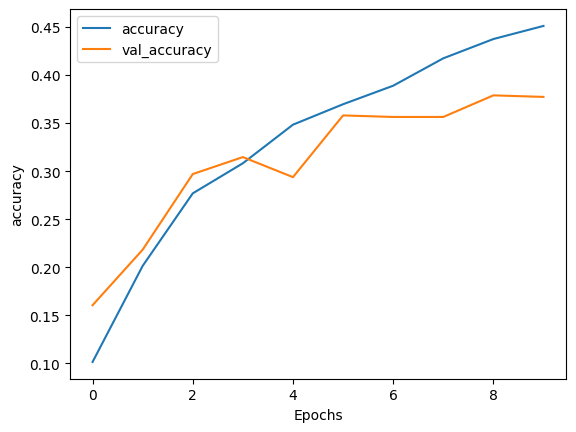

In [41]:
plot_graghs(history_simple, 'accuracy')

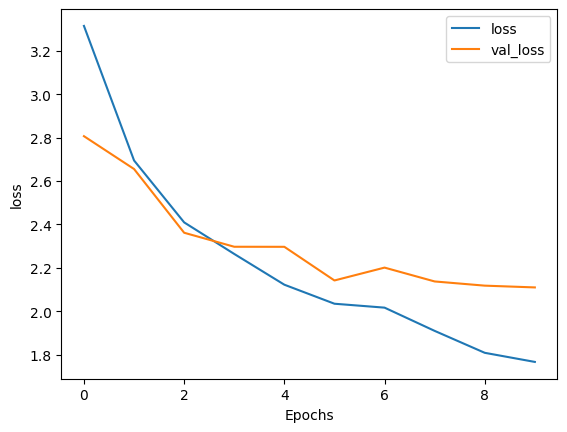

In [42]:
plot_graghs(history_simple, 'loss')